# 1- Importing libs


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
# for reproducibility , to get the same results when evry your run
np.random.seed(2021) 

import re
import string
from collections import Counter

import scipy.spatial
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.svm import LinearSVC
import xgboost as xgb


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams


from tqdm import tqdm
from pprint import pprint

import sys
import os
import glob
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [93]:
PATH = '../input/good-reads-quotes'

In [94]:
quotes_multi_label_data = pd.read_csv(PATH + '/popular_quotes.csv')
quotes_multi_label_data.head()

,quotes,tags
0,Be yourself; everyone else is already taken.,"['attributed-no-source', 'be-yourself', 'hones..."
1,"I'm selfish, impatient and a little insecure. ...","['attributed-no-source', 'best', 'life', 'love..."
2,Two things are infinite: the universe and huma...,"['attributed-no-source', 'human-nature', 'humo..."
3,"So many books, so little time.","['books', 'humor']"
4,A room without books is like a body without a ...,"['attributed-no-source', 'books', 'simile', 's..."


# 2- Pre-processing

In [95]:
def plot_freq(data, st):
    '''
        take the data, and st refeere to kind of sentiment
    '''
    plt.figure(figsize=(12, 6))
    sns.barplot(data= data , x= 'counts', y= 'word')
    plt.title(f'Top 20 words in {st} quotes')
    plt.show();

In [96]:
stop_words = stopwords.words('english')
stemmer    = nltk.SnowballStemmer("english")

In [97]:
def clean_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''
    # text = re.findall('“([^"]*)”', text)[0] # extract text for quotations
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [98]:
def preprocess_data(text):
    # text = remove_quotations(text)                                            # extract text for quotations
    text = clean_text(text)                                                     # Clean puntuation, urls, and so on
    text = ' '.join(word for word in text.split() if word not in stop_words)    # Remove stopwords
    text = ' '.join(stemmer.stem(word) for word in text.split())                # Stemm all the words in the sentence
    return text

**Here the tags col has a str type instate of list for each quote, so we will convert it to list**

In [99]:
print(quotes_multi_label_data['tags'][0])
print(type(quotes_multi_label_data['tags'][0]))
print(quotes_multi_label_data['tags'][0][0]) # print char instate of str as a tag word

['attributed-no-source', 'be-yourself', 'honesty', 'inspirational', 'misattributed-oscar-wilde']
<class 'str'>
[


In [100]:
# make a preprocessing pipeline 
quotes_multi_label_data['clean_text'] = quotes_multi_label_data['quotes'].apply(preprocess_data)

# remove ' and , from the string and [] and spliting the tags
quotes_multi_label_data['tags'] = quotes_multi_label_data['tags'].apply(lambda tags: tags.replace("'","").replace(",","")[1:-1].split())

# get the len of number of tags in each quote
quotes_multi_label_data['n_tags'] = quotes_multi_label_data['tags'].apply(lambda tags: len(tags))
quotes_multi_label_data.head()

,quotes,tags,clean_text,n_tags
0,Be yourself; everyone else is already taken.,"[attributed-no-source, be-yourself, honesty, i...",everyon els alreadi taken,5
1,"I'm selfish, impatient and a little insecure. ...","[attributed-no-source, best, life, love, mista...",im selfish impati littl insecur make mistak co...,8
2,Two things are infinite: the universe and huma...,"[attributed-no-source, human-nature, humor, in...",two thing infinit univers human stupid im sure...,8
3,"So many books, so little time.","[books, humor]",mani book littl time,2
4,A room without books is like a body without a ...,"[attributed-no-source, books, simile, soul]",room without book like bodi without soul,4


In [101]:
print(quotes_multi_label_data['tags'][0])
print(type(quotes_multi_label_data['tags'][0]))
print(quotes_multi_label_data['tags'][0][0]) # print char instate of str as a tag word

['attributed-no-source', 'be-yourself', 'honesty', 'inspirational', 'misattributed-oscar-wilde']
<class 'list'>
attributed-no-source


**Here we converted the list as a string to actual list type**

### Distribution on number of tags

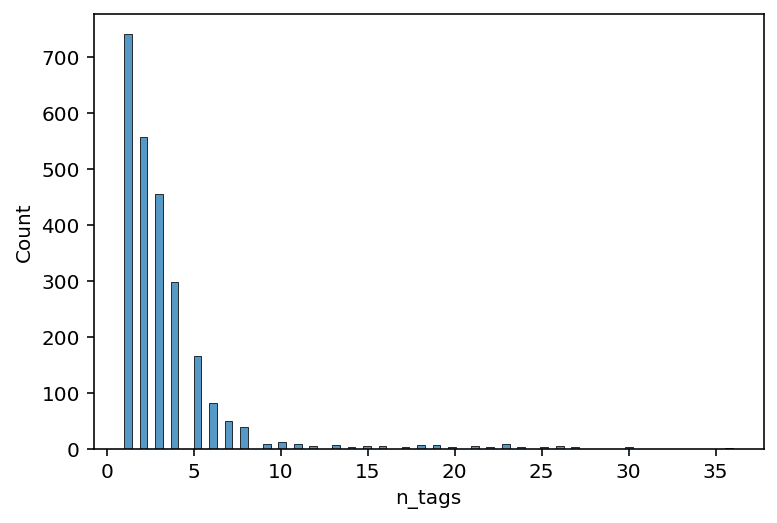

In [102]:
sns.histplot(data= quotes_multi_label_data, x= 'n_tags');

### Make a list of frequent tags

In [103]:
tag_list = [word for sent in quotes_multi_label_data['tags'] for word in sent]

In [104]:
len(tag_list)

7997

In [105]:
freq_tags = Counter(tag_list)
freq_tags_sorted = sorted(freq_tags.items(), key=lambda pair: pair[1], reverse=True)
freq_tags_df = pd.DataFrame(freq_tags_sorted, columns=['word', 'counts'])
freq_tags_df[:20].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
word,love,inspirational,life,humor,books,inspiration,reading,happiness,writing,inspirational-quotes,friendship,wisdom,philosophy,truth,attributed-no-source,optimism,living,life-quotes,hope,death
counts,319,318,294,253,136,85,84,66,66,65,63,62,59,57,53,48,48,48,46,46


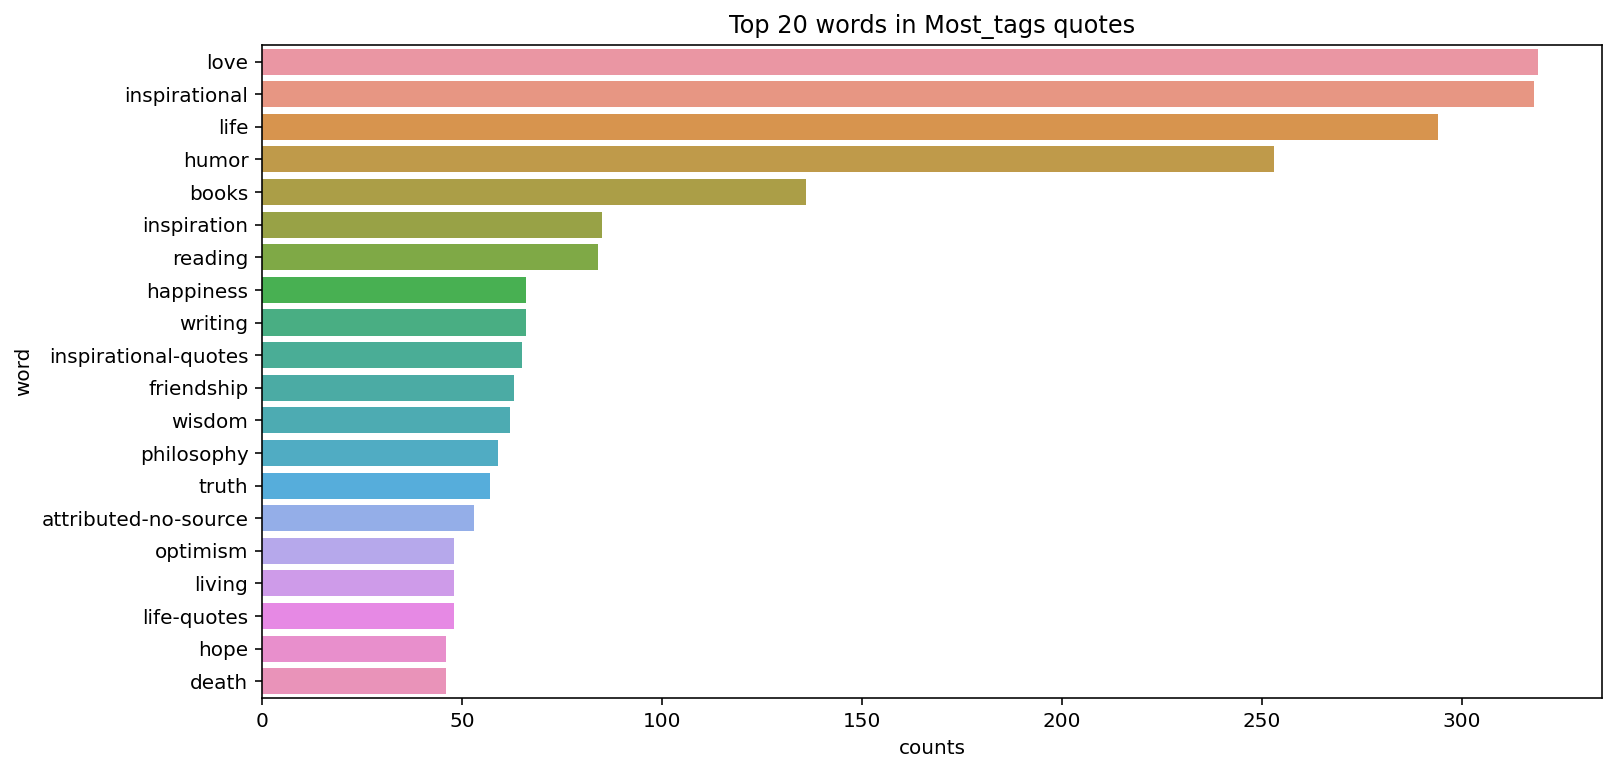

In [106]:
plot_freq(freq_tags_df[:20], 'Most_tags')

# 3- Modeling

## Simple Predecting Method

**The simplest way to make a multi-label classification is just to take all labels in the dataset and check if the piece of a word in the exact quote is belongs to the whole labels and get this label\s!**

**The sequance:**
* Make a list of all original unique labels.
* Make a list of all unique labels but cleaned. 
* Make a dict with {'cleaned_tag": 'original_tag'}.
* After taking the quote, make a preprocess on it then check if any word belong the cleaned_labels, if it .. get the original labels from the dict.


In [107]:
all_original_tags = list(set(tag_list))

# this ->" ".join(tag for tag in most_20_tags) .. to make it like a text for working well, and split them againe
# all_cleaned_tags = preprocess_data(" ".join(tag for tag in all_original_tags)).split()
all_cleaned_tags = [preprocess_data(tag) for tag in all_original_tags]

# {'cleaned_tag": 'original_tag'}
tags_dict = dict([(preprocess_data(tag), tag) for tag in all_original_tags])


In [108]:
def simple_multi_label(text):
    text = preprocess_data(text)
    labels_ = []
    for word in text.split():
        if word in all_cleaned_tags:
            labels_.append(tags_dict[word])
    return labels_

In [109]:
quote = "I love reading books and also playing football!"
print(f'The predicted labels: {simple_multi_label(quote)}')

The predicted labels: ['love', 'read', 'book', 'plays']


In [110]:
quote = "A friend is someone who knows all about you and still loves you."
print(f'The predicted labels: {simple_multi_label(quote)}')

The predicted labels: ['friend', 'knowing', 'love']


## FuzzyWuzzy 

* Fuzzywuzzy is a Python library uses **Levenshtein Distance** to calculate the differences between sequences in a simple-to-use package.

* **We will use this lib for sent similarity between the quote and top 10 tags.**
* **ratio**, compares the entire string similarity, in order.
* **partial_ratio**, compares partial string similarity.
* **token_sort_ratio**, ignores word order and ignores duplicated words.


In [111]:
from fuzzywuzzy import fuzz

In [112]:
q1 = quotes_multi_label_data['quotes'][7]
t1 = quotes_multi_label_data['tags'][7]
print(q1)
print(t1)

You know you're in love when you can't fall asleep because reality is finally better than your dreams.
['attributed-no-source', 'dreams', 'love', 'reality', 'sleep']


In [113]:
top_20_tag = list(freq_tags_df['word'][:20])
top_20_tag

['love',
 'inspirational',
 'life',
 'humor',
 'books',
 'inspiration',
 'reading',
 'happiness',
 'writing',
 'inspirational-quotes',
 'friendship',
 'wisdom',
 'philosophy',
 'truth',
 'attributed-no-source',
 'optimism',
 'living',
 'life-quotes',
 'hope',
 'death']

In [114]:
# we just need at most top 10 tags
top_10_tag = top_20_tag[:10]
top_10_tag

['love',
 'inspirational',
 'life',
 'humor',
 'books',
 'inspiration',
 'reading',
 'happiness',
 'writing',
 'inspirational-quotes']

**fuzz.ratio**

In [115]:
tags_scores = []
sim_tags = []
for tag in top_10_tag:
    score = fuzz.ratio(q1,tag)
#     print(f'The similarity of {tag} tag is: {score}') # compares the entire string similarity, in order
    tags_scores.append((score, tag))
    
tags_scores.sort(reverse = True)
# print(tags_scores)
for item in tags_scores:
    sim_tags.append(item[1])
print(sim_tags[:5])

['inspirational-quotes', 'inspirational', 'inspiration', 'happiness', 'writing']


**fuzz.partial_ratio**

In [116]:
tags_scores = []
sim_tags = []
for tag in top_10_tag:
    score = fuzz.partial_ratio(q1,tag)
#     print(f'The similarity of {tag} tag is: {score}') # compares the entire string similarity, in order
    tags_scores.append((score, tag))
    
tags_scores.sort(reverse = True)
# print(tags_scores)
for item in tags_scores:
    sim_tags.append(item[1])
print(sim_tags[:5])

['love', 'reading', 'life', 'inspirational', 'writing']


**fuzz.token_sort_ratio**

In [117]:
tags_scores = []
sim_tags = []
for tag in top_10_tag:
    score = fuzz.token_sort_ratio(q1,tag)
#     print(f'The similarity of {tag} tag is: {score}') # compares the entire string similarity, in order
    tags_scores.append((score, tag))
    
tags_scores.sort(reverse = True)
# print(tags_scores)
for item in tags_scores:
    sim_tags.append(item[1])
print(sim_tags[:5])

['inspirational-quotes', 'inspirational', 'inspiration', 'happiness', 'writing']


**By the experimental i'll use `partial_ratio`**

In [118]:
def fuzzywuzzy_sim(q):
    tags_scores = []
    sim_tags = []
    for tag in top_10_tag:
        score = fuzz.partial_ratio(q,tag)
        tags_scores.append((score, tag))

    tags_scores.sort(reverse = True)
    for item in tags_scores:
        sim_tags.append(item[1])
    return sim_tags[:5]

In [119]:
q = "If you don't belong, don't be long!"
print(f'The predicted labels: {fuzzywuzzy_sim(q)}')

The predicted labels: ['love', 'reading', 'humor', 'books', 'inspiration']


In [120]:
q = "We always needs the close people who says you are on the road, just keep going and don’t turn around."
print(f'The predicted labels: {fuzzywuzzy_sim(q)}')

The predicted labels: ['love', 'inspiration', 'writing', 'reading', 'humor']


In [121]:
q = "Even superman sometimes needed to superwoman soul!"
print(f'The predicted labels: {fuzzywuzzy_sim(q)}')

The predicted labels: ['inspiration', 'love', 'life', 'inspirational-quotes', 'inspirational']


## Machine Learning Model

### Custimize tags

Makes a list of top 10 tags and iterate over each original tags, if any one from the top_10 add it.

Here we found 3 tags have the same tag!
[inspirational-quotes, inspirational, inspiration], we will just keep on of them 'inspirational'

In [122]:
'inspirational' in top_20_tag, 'inspiration' in top_20_tag, 'inspirational-quotes' in top_20_tag

(True, True, True)

In [123]:
top_20_tag.remove('inspiration'), top_20_tag.remove('inspirational-quotes')

(None, None)

In [124]:
'inspirational' in top_20_tag, 'inspiration' in top_20_tag, 'inspirational-quotes' in top_20_tag

(True, False, False)

In [125]:
def customize_tags(tags):
    
    '''
        Here we will make a custome list of tags , if the original list of tags <= 5 take all original tags
        else expand it to be of len 5
    '''   
    tmp_list = [] 
    if len(tags) <= 5:
        return tags
    tmp_list = list(set(tags) & set(top_10_tag)) 
    tmp_list += top_10_tag[:2]
    tmp_list = list(set(tmp_list))
    return tmp_list


def make_top_5_tags(li):
    '''
        Make a random 5 tags from top 10 tags, to make it easy for modeling.
        Just take random 5 tags from the top 10 tags, and most of of top 10 tags in each row.
    '''
    return random.sample(top_10_tag, 5)
                


In [126]:
quotes_multi_label_data['customize_tags'] = quotes_multi_label_data['tags'].apply(customize_tags)
quotes_multi_label_data['customize_top_5_tags'] = quotes_multi_label_data['tags'].apply(lambda tags: random.sample(top_10_tag,5))
quotes_multi_label_data.head(10)


,quotes,tags,clean_text,n_tags,customize_tags,customize_top_5_tags
0,Be yourself; everyone else is already taken.,"[attributed-no-source, be-yourself, honesty, i...",everyon els alreadi taken,5,"[attributed-no-source, be-yourself, honesty, i...","[reading, writing, life, inspirational, happin..."
1,"I'm selfish, impatient and a little insecure. ...","[attributed-no-source, best, life, love, mista...",im selfish impati littl insecur make mistak co...,8,"[life, love, inspirational]","[inspiration, books, reading, inspirational, h..."
2,Two things are infinite: the universe and huma...,"[attributed-no-source, human-nature, humor, in...",two thing infinit univers human stupid im sure...,8,"[humor, love, inspirational]","[writing, humor, love, inspirational, reading]"
3,"So many books, so little time.","[books, humor]",mani book littl time,2,"[books, humor]","[writing, inspirational-quotes, humor, books, ..."
4,A room without books is like a body without a ...,"[attributed-no-source, books, simile, soul]",room without book like bodi without soul,4,"[attributed-no-source, books, simile, soul]","[happiness, inspirational-quotes, love, readin..."
5,"Be who you are and say what you feel, because ...","[ataraxy, be-yourself, confidence, fitting-in,...",say feel mind dont matter matter dont mind,7,"[love, inspirational]","[life, books, humor, inspiration, writing]"
6,You've gotta dance like there's nobody watchin...,"[dance, heaven, hurt, inspirational, life, lov...",youv gotta danc like there nobodi watchinglov ...,7,"[life, love, inspirational]","[books, love, reading, happiness, inspirational]"
7,You know you're in love when you can't fall as...,"[attributed-no-source, dreams, love, reality, ...",know your love cant fall asleep realiti final ...,5,"[attributed-no-source, dreams, love, reality, ...","[love, humor, happiness, books, life]"
8,"You only live once, but if you do it right, on...","[humor, life]",live right enough,2,"[humor, life]","[writing, inspirational-quotes, reading, humor..."
9,Be the change that you wish to see in the world.,"[action, change, inspirational, philosophy, wish]",chang wish see world,5,"[action, change, inspirational, philosophy, wish]","[inspirational, books, inspiration, writing, l..."


In [127]:
# test the function
quotes_multi_label_data['tags'][1],quotes_multi_label_data['customize_tags'][1],quotes_multi_label_data['customize_top_5_tags'][1]

(['attributed-no-source',
  'best',
  'life',
  'love',
  'mistakes',
  'out-of-control',
  'truth',
  'worst'],
 ['life', 'love', 'inspirational'],
 ['inspiration', 'books', 'reading', 'inspirational', 'happiness'])

In [128]:
# test the function
quotes_multi_label_data['tags'][3], quotes_multi_label_data['customize_tags'][3],quotes_multi_label_data['customize_top_5_tags'][3]

(['books', 'humor'],
 ['books', 'humor'],
 ['writing', 'inspirational-quotes', 'humor', 'books', 'life'])

In [129]:
multi_label = MultiLabelBinarizer()
y = multi_label.fit_transform(quotes_multi_label_data['customize_top_5_tags'])

In [130]:
multi_label.classes_

array(['books', 'happiness', 'humor', 'inspiration', 'inspirational',
       'inspirational-quotes', 'life', 'love', 'reading', 'writing'],
      dtype=object)

In [131]:
pd.DataFrame(y, columns= multi_label.classes_)

,books,happiness,humor,inspiration,inspirational,inspirational-quotes,life,love,reading,writing
0,0,1,0,0,1,0,1,0,1,1
1,1,1,0,1,1,0,0,0,1,0
2,0,0,1,0,1,0,0,1,1,1
3,1,0,1,0,0,1,1,0,0,1
4,0,1,0,0,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
2476,0,1,0,0,1,1,1,1,0,0
2477,1,1,0,0,0,0,1,1,1,0
2478,0,1,0,0,0,0,1,1,1,1
2479,0,1,1,0,1,0,0,0,1,1


### TF-IDF Vectorizer

In [132]:
X_train, X_test, y_train, y_test = train_test_split(quotes_multi_label_data['clean_text'], y, test_size= .2, random_state= 2021)
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((1984,), (497,), (1984, 10), (497, 10))

In [133]:
tf_idf = TfidfVectorizer(analyzer= 'word', max_features= 10000, ngram_range= (1, 3))
X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)
X_train.shape, X_test.shape

((1984, 10000), (497, 10000))

### Building The Model

In [134]:
sgd = SGDClassifier()
lr = LinearRegression()
svc = LinearSVC()

In [135]:
def jaccard_score(y_true, y_pred):
    jaccard = np.minimum(y_true, y_pred).sum(axis= 1) / np.maximum(y_true, y_pred).sum(axis= 1)
    return jaccard.mean() * 100

def print_score(y_pred, clf):
    print("clf:", clf.__class__.__name__)
    print("Jaccard Score:", round(jaccard_score(y_test, y_pred),3))
    print('-'*20)

In [136]:
for classifier in [sgd, lr, svc]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

clf: SGDClassifier
Jaccard Score: 34.275
--------------------
clf: LinearRegression
Jaccard Score: 34.877
--------------------
clf: LinearSVC
Jaccard Score: 34.078
--------------------


**The accuracy it's too low, because the data is samll 2481 row data.**

### Model Testing

In [137]:
def ml_predicted_tags(sent):
    lebels = []
    xt = tf_idf.transform([sent])
    labels = list(multi_label.inverse_transform(clf.predict(xt))[0])
    return labels

In [138]:
q = "I'm happy when i am reading the holy Quran"
print(f'The predicted labels for ml_predicted_tags : {ml_predicted_tags(q)}')
print(f'The predicted labels for simple_multi_label : {simple_multi_label(q)}')
print(f'The predicted labels for fuzzywuzzy_sim : {fuzzywuzzy_sim(q)}')

The predicted labels for ml_predicted_tags : ['happiness', 'humor', 'inspirational-quotes', 'life', 'reading', 'writing']
The predicted labels for simple_multi_label : ['happiness', 'read', 'holiness']
The predicted labels for fuzzywuzzy_sim : ['reading', 'writing', 'happiness', 'inspiration', 'inspirational-quotes']


## Choosen my ML model

In [139]:
# sgd = SGDClassifier()
# clf = OneVsRestClassifier(sgd)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)


sgd = SGDClassifier()
clf = OneVsRestClassifier(sgd)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


### Model Testing

In [140]:
def ml_predicted_tags(q):
    tags = []
    x = tf_idf.transform([q])
    tags = list(multi_label.inverse_transform(clf.predict(x))[0]) 
    return tags

In [141]:
q = "i'm happy because i'm reading the hole Quran"
cleaned_q = preprocess_data(q)
print(ml_predicted_tags(cleaned_q))

['happiness', 'humor', 'inspiration', 'life']


In [142]:
def some_pred_funcs(q):
    l1 = ml_predicted_tags(q)
    l2 = simple_multi_label(q)
    l3 = fuzzywuzzy_sim(q)
    l4 = list(set(l1+l2+l3))
    return l4

In [143]:
q = "If you don't belong, don't be long!"
some_pred_funcs(q)

['happiness',
 'longing',
 'belonging',
 'books',
 'inspirational',
 'reading',
 'humor',
 'inspiration',
 'love']

## Deep Learning Model

#### Build The RoBERTa Model

In [155]:
import tensorflow as tf
import torch
import torchvision
from transformers import AutoTokenizer, AutoConfig

from transformers import TFRobertaModel, RobertaConfig, RobertaTokenizerFast
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential



In [145]:
# Name of the Roberta model to use
model_name = 'roberta-base'

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFRobertaModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

2021-11-21 22:03:37.090725: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-21 22:03:37.094657: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-21 22:03:37.117010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 22:03:37.117944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-21 22:03:37.118048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-21 22:03:37.121790: I tensorflow/stream_executor/platform/def

In [147]:
X_train, X_test, y_train, y_test = train_test_split(quotes_multi_label_data['quotes'], y, test_size= .2, random_state= 2021)
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((1984,), (497,), (1984, 10), (497, 10))

In [148]:
# This is work well
all_quotes = X_train.values

# Encode our concatenated data
encoded_qoutes = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_quotes]

# Find the maximum length
max_length_all_quotes_training = max([len(sent) for sent in encoded_qoutes])

print('Max length in traning: ', max_length_all_quotes_training)

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


Max length in traning:  856


In [149]:
# we choosen 38 because is the max lenght in evaluation
max_length_all_quotes_training = 30
print('Max length in traning: ', max_length_all_quotes_training)

# Load the MainLayer
roberta = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length_all_quotes_training,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length_all_quotes_training,), name='attention_mask', dtype='int32') 

inputs = {'input_ids': input_ids}

# Load the Transformers Roberta model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
labels = Dense(units=10, activation='sigmoid', kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='issue')(pooled_output)
# outputs = Dense(3, activation='softmax')(labels)
outputs = {'label': labels}

# And combine it all in a model object

model = Model(inputs=inputs, outputs=outputs, name='Roberta_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Max length in traning:  30
Model: "Roberta_MultiLabel_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 30)]              0         
_________________________________________________________________
roberta (TFRobertaMainLayer) TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
issue (Dense)                (None, 10)                7690      
Total params: 124,653,322
Trainable params: 124,653,322
Non-trainable params: 0
_________________________________________________________________


In [150]:
top_10_tag
quotes_multi_label_data.head()

,quotes,tags,clean_text,n_tags,customize_tags,customize_top_5_tags
0,Be yourself; everyone else is already taken.,"[attributed-no-source, be-yourself, honesty, i...",everyon els alreadi taken,5,"[attributed-no-source, be-yourself, honesty, i...","[reading, writing, life, inspirational, happin..."
1,"I'm selfish, impatient and a little insecure. ...","[attributed-no-source, best, life, love, mista...",im selfish impati littl insecur make mistak co...,8,"[life, love, inspirational]","[inspiration, books, reading, inspirational, h..."
2,Two things are infinite: the universe and huma...,"[attributed-no-source, human-nature, humor, in...",two thing infinit univers human stupid im sure...,8,"[humor, love, inspirational]","[writing, humor, love, inspirational, reading]"
3,"So many books, so little time.","[books, humor]",mani book littl time,2,"[books, humor]","[writing, inspirational-quotes, humor, books, ..."
4,A room without books is like a body without a ...,"[attributed-no-source, books, simile, soul]",room without book like bodi without soul,4,"[attributed-no-source, books, simile, soul]","[happiness, inspirational-quotes, love, readin..."


In [151]:
import math
valid_split = 0.2
batch_size_no = 32
epochs_no = 16
initial_lr = 5e-05
step_no = math.ceil(len(quotes_multi_label_data)/32)

In [157]:
# Set an optimizer
optimizer = Adam(
    learning_rate=initial_lr,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'label': BinaryCrossentropy(from_logits = True)}
# loss = {'label': CategoricalCrossentropy(from_logits = False)} # when i using it = False, get low accuracy!!
metric = {'label': BinaryAccuracy('accuracy')}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

# Ready output data for the model
# y_labels = to_categorical(y_train)
y_labels = y_train


# Tokenize the input (takes some time)
x = tokenizer(
#     text=quotes_multi_label_data.clean_text.tolist(),
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=max_length_all_quotes_training,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)


checkpoint_filepath = 'roberta_keras_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [158]:
%%time
# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'label': y_labels},
    validation_split=valid_split,
    batch_size=batch_size_no,
    epochs=epochs_no,
    callbacks=[model_checkpoint_callback]
    )


2021-11-21 22:08:53.054294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-21 22:08:53.065845: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000194999 Hz


Epoch 1/16
50/50 [==============================] - 30s 220ms/step - loss: 0.6955 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.5043
Epoch 2/16
50/50 [==============================] - 8s 168ms/step - loss: 0.6933 - accuracy: 0.5050 - val_loss: 0.6936 - val_accuracy: 0.4922
Epoch 3/16
50/50 [==============================] - 9s 180ms/step - loss: 0.6934 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.4924
Epoch 4/16
50/50 [==============================] - 8s 167ms/step - loss: 0.6932 - accuracy: 0.5086 - val_loss: 0.6933 - val_accuracy: 0.5038
Epoch 5/16
50/50 [==============================] - 8s 168ms/step - loss: 0.6932 - accuracy: 0.5065 - val_loss: 0.6930 - val_accuracy: 0.5023
Epoch 6/16
50/50 [==============================] - 9s 174ms/step - loss: 0.6930 - accuracy: 0.5102 - val_loss: 0.6930 - val_accuracy: 0.5020
Epoch 7/16
50/50 [==============================] - 8s 168ms/step - loss: 0.6928 - accuracy: 0.5137 - val_loss: 0.6930 - val_accuracy: 0.5065
Epoch

#### Evaluate the model


In [159]:
test_y_labels = y_test
test_y_labels.shape

(497, 10)

In [160]:
# Encode our concatenated data
encoded_test_quotes = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_test]
max_length_text_tweet_eval = max([len(sent) for sent in encoded_test_quotes]) 

max_length_text_quotes_eval = 30

# Ready test data
test_y_labels = y_test

test_x = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length = max_length_text_quotes_eval,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)


# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'label': test_y_labels}
)

16/16 [==============================] - 1s 54ms/step - loss: 0.7002 - accuracy: 0.4958


In [161]:
input_pred = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=max_length_text_quotes_eval,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

print("input_pred['input_ids'].shape:",input_pred['input_ids'].shape)

y_pred = model.predict(input_pred['input_ids'])

input_pred['input_ids'].shape: (497, 30)


In [162]:
print(y_pred['label'].shape)
y_pred = np.array([np.argmax(item) for item in y_pred['label']])
print(len(y_pred))

(497, 10)
497


In [163]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(quotes_multi_label_data.quotes.values)

In [164]:
sent = "Be yourserlf,everyone else is already taken."
txt = clean_text(sent)
# print(txt)
txt = tokenizer.texts_to_sequences([txt])
print(txt)
txt = pad_sequences(txt, maxlen=max_length_text_quotes_eval, padding='post' , dtype='int32')
print(txt)
# get probability for each class 
l = model.predict(txt,batch_size=1)['label'][0].tolist()
print(top_10_tag)
print(l)

[[12, 186, 7, 408, 650]]
[[ 12 186   7 408 650   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
['love', 'inspirational', 'life', 'humor', 'books', 'inspiration', 'reading', 'happiness', 'writing', 'inspirational-quotes']
[0.3509988784790039, 0.4452987015247345, 0.5835486650466919, 0.4623573124408722, 0.4358856976032257, 0.5804783701896667, 0.6492245197296143, 0.37995806336402893, 0.5453282594680786, 0.5649363994598389]


In [165]:
def dl_predicted_tags(q):
    txt = clean_text(sent)
    txt = tokenizer.texts_to_sequences([txt])
    txt = pad_sequences(txt, maxlen=max_length_text_quotes_eval, padding='post' , dtype='int32')
    # get probability for each class 
    ts = model.predict(txt,batch_size=1)['label'][0].tolist()
    predicted_tags_index = [ts.index(t) for t in ts if t >= .5]
    predicted_tags_labels = [top_10_tag[i] for i in predicted_tags_index]
    return predicted_tags_labels

#### Test all predicted methods


In [166]:
q = "Be yourserlf,everyone else is already taken."
print(f'The predicted labels: {simple_multi_label(q)}')
print(f'The predicted labels: {fuzzywuzzy_sim(q)}')
print(f'The predicted labels: {ml_predicted_tags(q)}')
print(f'The predicted labels: {dl_predicted_tags(q)}')

The predicted labels: []
The predicted labels: ['life', 'reading', 'love', 'inspirational', 'humor']
The predicted labels: ['inspiration', 'inspirational', 'reading', 'writing']
The predicted labels: ['life', 'inspiration', 'reading', 'writing', 'inspirational-quotes']


In [167]:
def comp_tags(q):
    simple_tags = simple_multi_label(q)
    fuzzwazzy   = fuzzywuzzy_sim(q)
    ml_tags     = ml_predicted_tags(q)
    dl_tags     = dl_predicted_tags(q)
    comp_tags   = list(set(simple_tags + fuzzwazzy + ml_tags+ dl_tags))
    return comp_tags[:10] if len(comp_tags) > 10 else comp_tags

In [168]:
q = "A friend is someone who knows all about you and still loves you"
print(f'The predicted labels: {comp_tags(q)}')

The predicted labels: ['books', 'life', 'inspirational', 'reading', 'writing', 'knowing', 'humor', 'friend', 'inspiration', 'inspirational-quotes']


### Referances:
[Multi-Label Text Classification](https://pianalytix.com/multi-label-text-classification/)


[TF-IDF from scratch in python on a real-world dataset](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)


[A quick tutorial on how to deploy your Streamlit app to Heroku.
](https://towardsdatascience.com/a-quick-tutorial-on-how-to-deploy-your-streamlit-app-to-heroku-874e1250dadd)


[A quick tutorial on how to deploy your Streamlit app to Heroku-video](https://www.youtube.com/watch?v=zK4Ch6e1zq8)